As per the [Wolrd Health Organization](https://www.who.int/health-topics/coronavirus), Coron Viruses (CoV) are a family of viruses that cause illnesses ranging from common to sever diseases. The Novel CoronoVirus(nCoV or COVID-19) is a new strain that had not been previously identified in the humans. The World Health Organization first reported the outbreak of Corona Virus Disease (COVID-19) on Decemeber 31, 2019. You can follow the updates on COVID-19 outbreak from [WHO](https://www.who.int/emergencies/diseases/novel-coronavirus-2019).

Today we'll analyze the COVID-19 outbreak around the world. How is the outbreak spreading, and how are the infected people recovering around the world. 

## Outbreak analysis
Let's start with the latest stats on the COVID-19 outbreak.

In [1]:
# Imports
# Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
#! pip install calmap
#import calmap
import folium

# Load the dataset
outbreak = pd.read_csv('../data/covid_19_data.csv',parse_dates=['ObservationDate'])

# Data cleaning
# Rename the columns for easy use
outbreak = outbreak.rename(columns={'Country/Region':'Country','ObservationDate':'Date','Province/State':'State'})

# Combine the counts from China.
outbreak.Country = outbreak.Country.str.replace('Mainland China','China')

outbreakOverall = outbreak.groupby('Date')['Confirmed','Deaths','Recovered'].sum()
outbreakOverall.reset_index(inplace=True)
outbreakOverall['Active'] = outbreakOverall.Confirmed - outbreakOverall.Deaths - outbreakOverall.Recovered

latest = outbreakOverall[outbreakOverall.Date == max(outbreakOverall.Date)]
latest.style.background_gradient(cmap='Reds',axis=1)

,Date,Confirmed,Deaths,Recovered,Active
42,2020-03-04 00:00:00,95124,3254,51171,40699


Let's take a look at the overall trend for the spread of COVID-19 over the days.

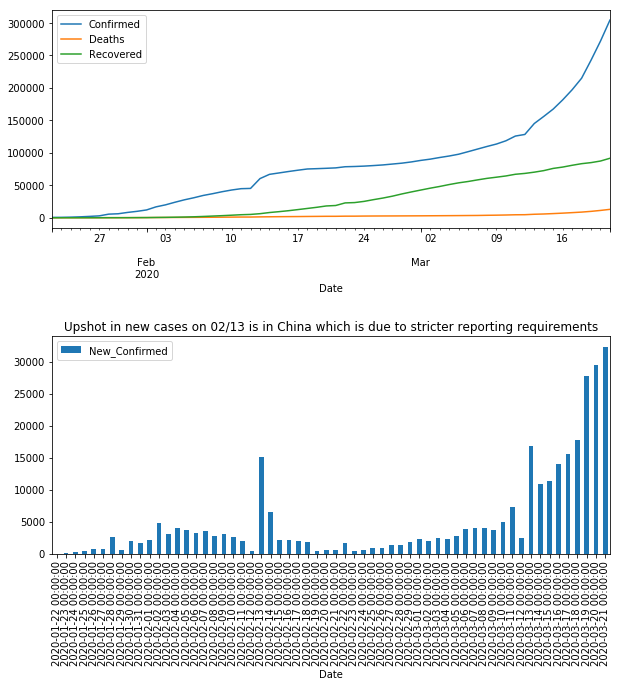

In [2]:
# Compute the first degree of differences
outbreakOverall['New_Confirmed'] = outbreakOverall.Confirmed.diff()
outbreakOverall['New_Recovered'] = outbreakOverall.Recovered.diff()
outbreakOverall['New_Deaths']    = outbreakOverall.Deaths.diff()

# Let's get the axes
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot the charts
# ax1 : Confirmed cases, deaths and recovered cases by Date
outbreakOverall.plot(x='Date',y=['Confirmed','Deaths','Recovered'],kind='line', ax=ax1)

# ax2 : New Confirmations per day
outbreakOverall.plot(x='Date',y=['New_Confirmed'],kind='bar', ax=ax2,
                     title='Upshot in new cases on 02/13 is in China which is due to stricter reporting requirements')

plt.subplots_adjust(hspace = 0.5)

As can be seen from the above chart, the disease started spreading fast since 1st Feb 2020. 
* There was a huge burst of disease on Feb 13th. As per the news reports, the jump in new cases—more than 14,800 on Feb 13th in China at the epicenter of the outbreak—is due to a change in the criteria for counting diagnoses of the virus. For more information, please read the article [Hubei cases classification](https://time.com/5783401/covid19-hubei-cases-classification/)
* There is a second wave of exponential increase in early May. 

On the brighter side, the infected people also started recovering at a fast rate since mid Feb. 

Now, Let's try visualize the number of countries impacted over the time. 

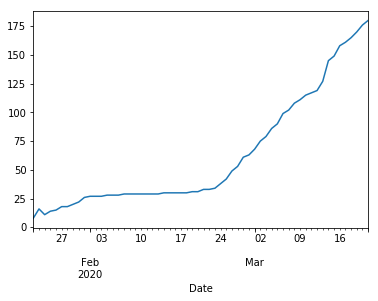

In [3]:
countriesOverTime = outbreak.groupby('Date').Country.nunique()
countriesOverTime.plot()

The number of countries impacted grew severly since Feb 24th. This could probably explain the exponential second wave of confirmed cases.

Now, let's visualize the global outbreak of COVID-19 by global map view.

In [4]:
outbreakByDateCountry = outbreak.groupby(['Date', 'Country'])['Confirmed', 'Deaths', 'Recovered'].max()
outbreakByDateCountry.reset_index(inplace=True)

outbreakByDateCountry['Date'] = outbreakByDateCountry['Date'].dt.strftime('%m/%d/%Y')
outbreakByDateCountry['size'] = outbreakByDateCountry.Confirmed.pow(0.3)

fig = px.scatter_geo(outbreakByDateCountry, locations="Country", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country",hover_data=['Confirmed','Deaths'],
                     range_color= [0, max(outbreakByDateCountry['Confirmed'])], 
                     projection="natural earth", animation_frame="Date", 
                     title='Spread over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

Let's visualize the number of deaths due to COVID-19 around the world over the time.

In [5]:
outbreakByDateCountry['DeathsSize'] = outbreakByDateCountry.Deaths.pow(0.5)
fig = px.scatter_geo(outbreakByDateCountry, locations="Country", locationmode='country names', 
                     size='DeathsSize', hover_name="Country", hover_data=['Deaths'],
                     projection="natural earth", animation_frame="Date",
                     color_continuous_scale='red',
                     # color_discrete_map='red',
                     title='Deaths over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

## Recovery
Let's try and get a sense of the recovery trend.

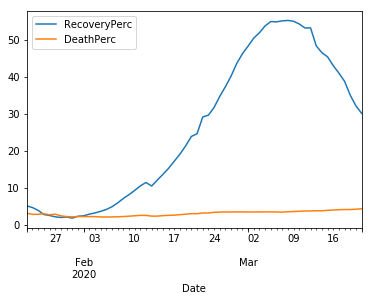

In [6]:
outbreakOverall['ActivePerc'] = outbreakOverall.Active * 100.0 / outbreakOverall.Confirmed
outbreakOverall['RecoveryPerc'] = outbreakOverall.Recovered * 100.0 / outbreakOverall.Confirmed
outbreakOverall['DeathPerc'] = outbreakOverall.Deaths * 100.0 / outbreakOverall.Confirmed

outbreakOverall.plot(x='Date',y=['RecoveryPerc', 'DeathPerc'],kind='line')

As can be seen from the above chart, the number of people Recovered from COVID-19 started increasing exponentially since Feb 13th. The trend started to decline early March as the number of cases started to increase exponentially. So, the overall recovery percent started to come down.

## Speed of COVID-19 outbreak and recovery
Let's try and analyze how fast is the disease spreading and how fast the people are recovering!


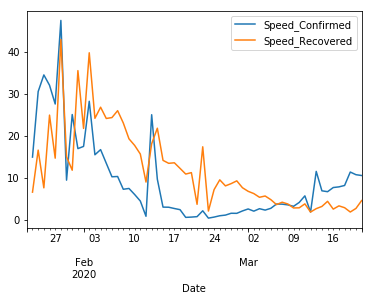

In [7]:
# Compute the speed of spread, recovery and death
outbreakOverall['Speed_Confirmed'] = outbreakOverall.New_Confirmed * 100.0 / outbreakOverall.Confirmed
outbreakOverall['Speed_Recovered'] = outbreakOverall.New_Recovered * 100.0 / outbreakOverall.Recovered
outbreakOverall['Speed_Deaths'] = outbreakOverall.New_Deaths * 100.0 / outbreakOverall.Deaths

outbreakOverall.plot(x='Date',y=['Speed_Confirmed','Speed_Recovered'],kind='line')

The COVID-19 was spreading at close to 50% each day at the end of Jan. **Since Jan 31st, the speed of recovery has overtaken the speed with which the disease was spreading.** 

Now that we are hopeful that the infected people are recovering faster, let's try and analyze the outbreak of the disease by each country.

In [8]:
outbreakByCountry = outbreak.groupby(['Date','Country'])['Confirmed','Deaths','Recovered'].sum()
outbreakByCountry.reset_index(inplace=True)

latestByCountry = outbreakByCountry[outbreakByCountry.Date == max(outbreakByCountry.Date)].sort_values('Confirmed',ascending=False)

latestByCountry['ConfirmedPerc'] = latestByCountry.Confirmed * 100/ latestByCountry.Confirmed.sum()
latestByCountry.head(10)

,Date,Country,Confirmed,Deaths,Recovered,ConfirmedPerc
3607,2020-03-21,China,81014.0,3255.0,71749.0,26.603137
3657,2020-03-21,Italy,53578.0,4825.0,6072.0,17.593784
3744,2020-03-21,US,25493.0,307.0,171.0,8.371316
3728,2020-03-21,Spain,25374.0,1375.0,2125.0,8.332239
3635,2020-03-21,Germany,22213.0,84.0,233.0,7.294239
3653,2020-03-21,Iran,20610.0,1556.0,7635.0,6.767851
3630,2020-03-21,France,14308.0,562.0,12.0,4.698419
3727,2020-03-21,South Korea,8799.0,102.0,1540.0,2.889389
3733,2020-03-21,Switzerland,6575.0,75.0,15.0,2.159079
3743,2020-03-21,UK,5067.0,234.0,67.0,1.663886


As on March 9th, China had the largest impact with 71% Confirmed amongst over world with Italy(8%), South Korea(6.5%) and Iran(6.3%) following. 

# Outbreak in US

Here are the top 10 US states with COVID-19 outbeak.

In [9]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

states = dict(zip(states.values(), states.keys()))

US = outbreak[outbreak.Country == 'US']
US = US[~US['State'].isin(['Diamond Princess', 'Grand Princess'])]
US['StateCode'] = US.State.map(states)
latestUS = US[US.Date == max(US.Date)]
latestUS.sort_values('Confirmed',ascending=False)[['Date','State','Confirmed','Deaths']].head(10).style.background_gradient(cmap='Reds')

,Date,State,Confirmed,Deaths
7319,2020-03-21 00:00:00,New York,11710,60
7327,2020-03-21 00:00:00,Washington,1793,94
7330,2020-03-21 00:00:00,California,1364,24
7331,2020-03-21 00:00:00,New Jersey,1327,16
7344,2020-03-21 00:00:00,Michigan,788,5
7347,2020-03-21 00:00:00,Illinois,753,6
7352,2020-03-21 00:00:00,Florida,659,13
7354,2020-03-21 00:00:00,Louisiana,585,16
7355,2020-03-21 00:00:00,Texas,581,5
7361,2020-03-21 00:00:00,Massachusetts,525,1


* The number of confirmed cases in NY shot up from 2K to 12K in just 4 days.
* Washington, California and New Jersey are following in chart who have already taken initiatives on COVID-19 control. 
* ***Michigan, Illinois, Florida, Louisiana, Texas and Massachusetts have shown sudden increase since 3/15.***

Note: Unfortunately, the data is mission for the US states for the whole month of Feb. So, you might see some empty map in the middle. This also makes our above reports for US over the month of Feb unreliable.

Now, let's look at the latest confirmed cases across US states.

In [10]:
fig = px.choropleth(latestUS, locations='StateCode', locationmode="USA-states", color='Confirmed', scope="usa", color_continuous_scale="Sunsetdark", 
                   hover_data = ['State', 'Confirmed', 'Deaths', 'Recovered'], title='COVID-19 Outbreak across US states')
fig.show()

In [11]:
US['DateStr'] = US['Date'].dt.strftime('%m/%d/%Y')
US['size'] = US.Confirmed.pow(0.3)

fig = px.scatter_geo(US, locations='StateCode', locationmode="USA-states", color='Confirmed', scope="usa",
                   size='size', hover_data = ['State', 'Confirmed', 'Deaths', 'Recovered'], title='COVID-19 Outbreak across US states over time'
                   #,projection="natural earth"
                    ,range_color= [0, max(US['Confirmed'])]
                    , animation_frame="DateStr"
                   )
fig.show()

In [12]:
fig = px.line(US, x="Date", y="Confirmed", color='State', title='Confirmed cases in US by state', height=600)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

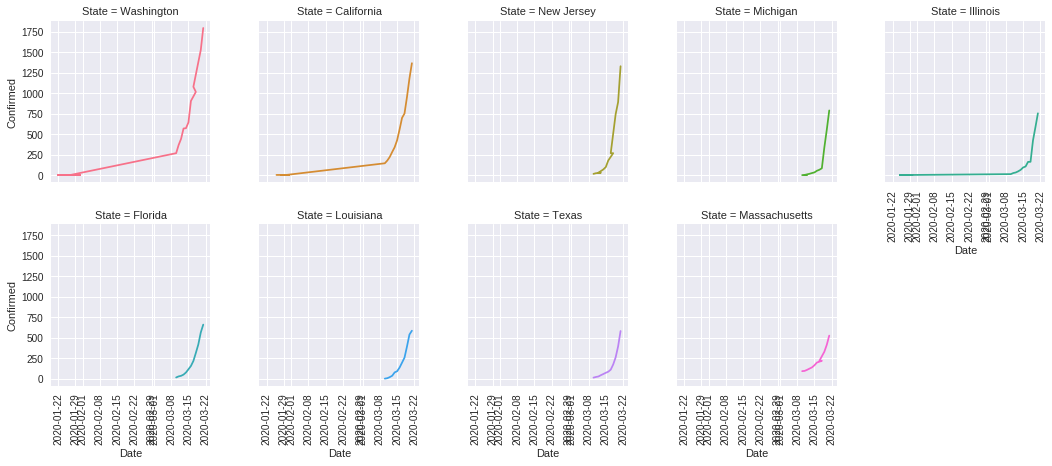

In [13]:
TopStates = [#'New York',
 'Washington',
 'California',
 'New Jersey',
 'Michigan',
 'Illinois',
 'Florida',
 'Louisiana',
 'Texas',
 'Massachusetts']

plt.style.use('seaborn')
USTopStates = US[US.State.isin(TopStates)].sort_values('Confirmed',ascending=False)
g = sns.FacetGrid(USTopStates, col="State", hue="State", 
                  sharey=True, col_wrap=5)
g = g.map(plt.plot, "Date", "Confirmed")
g.set_xticklabels(rotation=90)
plt.show()

As can be seen in the above charts for the top US states (excluding NY) have started showing sudden surge since 3/15. These states might also go under stay-in home/quarantine situation soon. 

There will be more insights coming up. Please follow the notebook for updates. Also, please share if you are looking for anything specific that could provide better insights into the COVID-19 outbreak. 